In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 1
SEGMENT = 1

ELECTRON = False
G_COORD = False
L_COORD = False

EPOCH = 200

In [6]:
VIEW_BOUND = (-500, 500)
AIR_BOUND = (-500, -426)
BONE_BOUND = (400, 500)
if ELECTRON:
    VIEW_BOUND = (0.5, 1.5)
    AIR_BOUND = (0.5, 0.5009)
    BONE_BOUND = (1.2, 1.2009)    

# Read Data

In [7]:
from codes.dataset import DicomsSegmentDataset, DicomSegmentDataset
import codes.augmentation as aug

In [8]:
pelvic_train_case_path = 'L1_pelvic_processed/train/*_*'
pelvic_train_id_case_path = 'L1_pelvic_processed/train_id/*_*'
pelvic_test_case_path = 'L1_pelvic_processed/test/*_*'

In [9]:
trainset_pelvic = DicomsSegmentDataset(pelvic_train_case_path, 
                   intensity_aug=None, geometry_aug=aug.get_validation_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
trainset_id_pelvic = DicomsSegmentDataset(pelvic_train_id_case_path, 
                   intensity_aug=None, geometry_aug=aug.get_validation_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)

In [10]:
testset = DicomsSegmentDataset(pelvic_test_case_path, geometry_aug=aug.get_validation_augmentation(), 
                 identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)

In [11]:
len(trainset_pelvic), len(trainset_id_pelvic), len(testset)

(1204, 1204, 656)

In [12]:
dataset = ConcatDataset([trainset_pelvic, trainset_id_pelvic, testset])

In [13]:
paths = sorted(glob.glob(pelvic_train_case_path))
for i in range(0, len(paths), 2):
    scans = DicomSegmentDataset(cbct_path=paths[i+1], ct_path=paths[i],
                         geometry_aug=None, intensity_aug=None, 
                         identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
    patient_id = scans.patientID()
    print(patient_id, len(scans))

A103591063 26
D101091741 26
E102430878 27
F122741131 26
F202106067 28
L221901764 26
M100783863 26
M100833788 26
M100876792 26
M2010548721 27
M201112299 26
M220615895 28
N102643578 28
P100018363 27
P100282238 26
P100316846 26
P100884858 26
P101153852 28
P1013795892 26
P101550351 27
P101580537 27
P1019886311 27
P1019886312 24
P102172968 26
P1200675951 29
P120092150 27
P120347927 26
P1203832092 27
P120865895 26
P1208685651 26
P1208685652 24
P200331961 28
P200376675 27
P2003862881 27
P201325743 27
P201328066 28
P2013447391 27
P2013447392 26
P201888503 30
P202079526 27
P202182082 26
P220293506 26
Q101391880 27
Q121027005 30
Q202733188 27


In [14]:
paths = sorted(glob.glob(pelvic_train_id_case_path))
for i in range(0, len(paths), 2):
    scans = DicomSegmentDataset(cbct_path=paths[i+1], ct_path=paths[i],
                         geometry_aug=None, intensity_aug=None, 
                         identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
    patient_id = scans.patientID()
    print(patient_id, len(scans))

E101507405 26
F102312670 27
I200025664 27
L221202686 26
M101147361 26
M2010548722 26
M220879175 28
M220971978 29
N102671269 26
N202765580 28
P100036727 27
P100199309 26
P100341901 27
P100749434 26
P101213693 27
P101313223 29
P101317169 26
P1013795891 26
P101829815 26
P101851906 26
P101979883 26
P1019886313 27
P102297648 27
P1200675952 29
P120411404 26
P121056229 28
P121195285 26
P200059535 26
P200264410 26
P200355596 27
P2003732182 28
P200415364 28
P2004683921 28
P2004683922 27
P200545769 26
P201091377 26
P201294985 26
P201978566 27
P223037591 26
Q101410166 27
Q101578449 27
Q102719828 26
Q102744009 26
Q102781995 26
Q202684457 27


In [15]:
paths = sorted(glob.glob(pelvic_test_case_path))
for i in range(0, len(paths), 2):
    scans = DicomSegmentDataset(cbct_path=paths[i+1], ct_path=paths[i],
                         geometry_aug=None, intensity_aug=None, 
                         identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
    patient_id = scans.patientID()
    print(patient_id, len(scans))

E201721694 31
F103360885 27
F221610264 28
J102238305 27
N103687369 27
N201482733 26
N203124823 30
N203214797 27
N222880999 29
P100200521 26
P100833146 26
P101017959 27
P101216363 26
P101343285 27
P101511265 26
P102043042 30
P102318099 26
P1203832091 26
P120917036 26
P2003732181 27
P2003862882 27
P200464992 26
P200596131 29
P201712862 29


In [16]:
def hu_histogram(dataset, ys, xs):
    for index, data in tqdm(enumerate(dataset)):
        x, y, *_ = data
        x = x.squeeze() * 1000 - 500
        y = y.squeeze() * 1000 - 500
        x_hist = np.histogram(x, bins=1000)[0]
        y_hist = np.histogram(y, bins=1000)[0]
        xs = np.add(x_hist, xs)
        ys = np.add(y_hist, ys)
        
    xs = xs/len(xs)
    ys = ys/len(ys)
    
    bins = np.arange(len(xs)) - 500
    
    plt.style.use("ggplot")
    fig = plt.figure() 
    ax = plt.subplot(111)
    
    ax.plot(bins, xs, label="CBCT", alpha=0.7)
    ax.plot(bins, ys, label="CT", alpha=0.7)
    ax.set_yscale("log")
   
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
    ax.fill_between(bins, 0, xs, alpha=0.5)
    ax.fill_between(bins, 0, ys, alpha=0.5)
    ax.set_xlabel("HU (CT number)")
    ax.set_ylabel("Intensity")
    fig.suptitle("HU histogram of L1 dataset")
#     plt.show()
    
    fig.savefig("L1 hu histogram.png")

3064it [02:08, 23.93it/s]


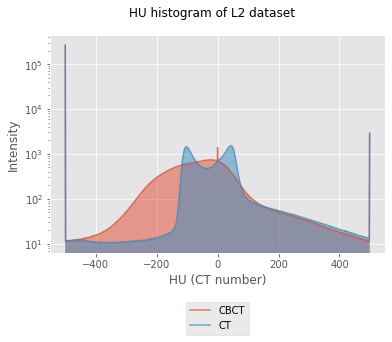

In [17]:
hu_histogram(dataset, np.zeros(1000), np.zeros(1000))